### Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth **MSA**).

**MSA** methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)

For this we will use the *homology* file obtained from MobiDB source, containing basic information about sequences: 
accession codes from UniProt, types of annotations, classes of proteins, source, start and end positions, content fraction, content count and ids of the regions. 

We will also use the files of FASTA format (*curated_uniprot.fasta_*) with the additional information of hsp regions and the amino acid sequences.

In [10]:
import argparse
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from os import path
import sys
import json
import os
import subprocess
from Bio.Blast import NCBIXML

In [2]:
# Check the current directory for assigning the variable for the functions below

print('Get current working directory : ', os.getcwd())

Get current working directory :  /Users/alina/Desktop/Internship-work/Internship


In [3]:
directory = "/Users/alina/Desktop/Internship-work/Internship"

In [4]:
'''
>ABCD123 (query, no gaps)
ABABABABBABABABABABBABABABABABA
>BCDS234 (match #1)
ABABABAB---BABABABABABA--BBABAB
>ADFSH35 (match #2)
ABABABABABABAB---BABABABABABABA
'''

'\n>ABCD123 (query, no gaps)\nABABABABBABABABABABBABABABABABA\n>BCDS234 (match #1)\nABABABAB---BABABABABABA--BBABAB\n>ADFSH35 (match #2)\nABABABABABABAB---BABABABABABABA\n'

In [5]:
# Iterate through each line of curated file
'''
with open("curated_uniprot.fasta_75") as f:
    # Iterate queries
    blast_records = NCBIXML.parse(f)
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
                    print("*****Hit*****")
                    print("sequence:", alignment.title)
                    print("length:", alignment.length)
                    print("e value:", hsp.expect)
                    print("query:", hsp.query)
                    print("match:", hsp.match)
                    print("subject:", hsp.sbjct)
                    print('Subject start', hsp.sbjct_start)
                    print("\n")
'''

'\nwith open("curated_uniprot.fasta_75") as f:\n    # Iterate queries\n    blast_records = NCBIXML.parse(f)\n    for blast_record in blast_records:\n        for alignment in blast_record.alignments:\n                    print("*****Hit*****")\n                    print("sequence:", alignment.title)\n                    print("length:", alignment.length)\n                    print("e value:", hsp.expect)\n                    print("query:", hsp.query)\n                    print("match:", hsp.match)\n                    print("subject:", hsp.sbjct)\n                    print(\'Subject start\', hsp.sbjct_start)\n                    print("\n")\n'

In [123]:
# Parse the fasta file to create a pandas dataframe

input_files = ['{}/curated_uniprot.fasta_75'.format(directory)]
dfs = []
max_query_length = 0

for input_file in input_files:
    with open(input_file) as f:
        blast_records = NCBIXML.parse(f)
        data = []

        # Iterate PSIBLAST rounds
        for blast_record in blast_records:
            query_id = blast_record.query

            # Get the length of the query sequence
            query_length = int(blast_record.query_letters)
            if query_length > max_query_length:
                max_query_length = query_length

            # Iterate alignments (here just one)
            for i, alignment in enumerate(blast_record.alignments):
                subject_id = alignment.title

                # Iterate pairwise alignments
                for hsp in alignment.hsps:
                    data.append((query_id,
                                    subject_id,
                                    query_length,
                                    hsp.query,
                                    hsp.match,
                                    hsp.sbjct,
                                    hsp.query_start,
                                    hsp.query_end,
                                    hsp.sbjct_start,
                                    hsp.sbjct_end,
                                    hsp.identities,
                                    hsp.positives,
                                    hsp.gaps,
                                    hsp.expect,
                                    hsp.score))

                    # Skip duplicated subjects
                    break

        dfs.append(pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                        "query_seq", "match_seq", "subject_seq",
                                    "query_start", "query_end", "subject_start", "subject_end", 
                                    "identity", "positive", "gaps", "eval", "bit_score"]))

In [124]:
# in this case the output will be the same as dfs without index, since we processed only one file - curated_uniprot.fasta_75
# but with the index the df looks nicer
df = dfs[0]
df

,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2R9BM51|A0A2R9BM51_PANPA Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
1,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
2,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
3,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|Q548C2|Q548C2_HUMAN Tyrosine-protein kinase...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
4,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.000000e+00,4458.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8651,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y5V3I1|A0A7Y5V3I1_9CHLR Extracellular s...,391,LVIALLVVSLVVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVE...,LV LL V + +P L IW + L +L F ++GV VE...,LVFGLLAVPALAQDRPDLLIWADRTRTPPLTELATTFAEEFGVTVE...,5,390,14,397,141,220,4,7.015510e-82,695.0
8652,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A2M8NZZ8|A0A2M8NZZ8_9CHLR Maltose ABC tra...,391,FLVIALLVVSLVVL----AQPKLTIWCSEKQVDILQKLGEEFKAKY...,L++A++ +L VL L IW + + IL+ LG +FK ++...,LLIVAVMFGALGVLNVRAQDATLLIWADDTRAPILEALGAKFKEEF...,4,387,9,405,152,241,29,7.935620e-82,679.0
8653,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A7Y2F1B7|A0A7Y2F1B7_9ACTN Maltose ABC tra...,391,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,L +W + + + + F+ GV +EVQ V+F DI+ + A...,SLLVWTDANRAPVFESIAPAFEEATGVNIEVQIVDFGDIREQVQVA...,21,387,71,436,133,208,3,1.031540e-81,681.0
8654,tr|Q9X0T1|Q9X0T1_THEMA Maltose ABC transporter...,tr|A0A101IFE6|A0A101IFE6_9CHLR Putative ABC tr...,391,KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIKSKFLTA...,+ IW E++ +L +L +F A+YGVE+ V+ N I+ +F A...,SIRIWADEQRAPVLSELATDFLAEYGVELVVE--NISGIRDQFSVA...,21,391,63,424,151,214,11,1.137790e-81,687.0


In [125]:
# Added ID

df['id'] = df['query_id'].str.split(" ").str[0]
df = df.set_index('id').reset_index()
df.head()

,id,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
0,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2R9BM51|A0A2R9BM51_PANPA Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
1,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A2J8MRP9|A0A2J8MRP9_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
2,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|A0A6D2VUB3|A0A6D2VUB3_PANTR Tyrosine-protei...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
3,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,tr|Q548C2|Q548C2_HUMAN Tyrosine-protein kinase...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0
4,sp|Q16620|NTRK2_HUMAN,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,sp|Q16620|NTRK2_HUMAN BDNF/NT-3 growth factors...,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0


In [135]:
# 2 columns, with the count correctly calculated
grouped = df.groupby(['query_seq', 'subject_seq']).size().reset_index(name='count')
grouped_counts = grouped.groupby('query_seq')['subject_seq'].nunique().reset_index(name='count')
grouped_counts.head()

,query_seq,count
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1


In [211]:
# Check how many hits we obtained

grouped_counts['count'].unique()

array([  1,   6,   2,   3,   4,  10,   5,   8,  51,  53,  22,  12,   9,
        20,  18,   7,  11,  14,  57,  55,  17,  16,  61, 108,  68,  24,
        91,  26,  30, 105,  41,  13,  27, 133,  76,  25,  65,  38,  15,
        43,  75,  33,  48,  29,  70,  23,  32,  64,  19,  21])

In [209]:
# Obtain the name of a particular query sequence to create a barplot

gc = grouped_counts[grouped_counts['count'] == 51]
gc['query_seq'].unique()

array(['DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNSSTLVSGKLVTKQPLLVNCLWPVPSFEEAASTFCFEGADFDQCNGAVLNNTVDVIRFNLNFTTNVQSGKGATVFSLNTTGGVTLEISCYNDTVSDSSFSSYGEIPFGVTNGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIDCISFNLTTGDSDVFWTIAYTSYTEALVQVENTAITNVTYCNSYVNNIKCSQLTANLNNGFYPVSSSEVGSVNKSVVLLPSFLTHTIVNITIGLGMKRSGYGQPIASTLSNITLPMQDNNTDVYCVRSDQFSVYVHSTCKSALWDNVFKRNCTDVLDATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDSIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRQTNRTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGTIVGAITSINSELLGLTHWTITPNFYYYSIYNYTNDKTRGTPIDSNDVGCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYIQVYTTPVSIDCSRYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSSETLDPIYTQWPNIGGFWLEGLKYILPSDNSKRKYRSAIEDLLFSKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGAFGGGAVSIPFAVAVQARLNYVALQTDVLNKNQQILASAFNQAIGNITQSFGKVNDAIHQTSRGLTTVAKALAKVQDVVNTQGQALRHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTA

In [185]:
# Filter df by a particular query_seq

#query_seq = 'MTERRLRVLVVEDESMIAMLIEDTLCELGHEVAATASRMQEALDIARKGQFDIAIIDVNLDGEPSYPVADILAERNVPFIFATGYGSKGLDTRYSNIPLLTKPFLDSELEAVLVQISKEV'
query_seq = 'DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNSSTLVSGKLVTKQPLLVNCLWPVPSFEEAASTFCFEGADFDQCNGAVLNNTVDVIRFNLNFTTNVQSGKGATVFSLNTTGGVTLEISCYNDTVSDSSFSSYGEIPFGVTNGPRYCYVLYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIDCISFNLTTGDSDVFWTIAYTSYTEALVQVENTAITNVTYCNSYVNNIKCSQLTANLNNGFYPVSSSEVGSVNKSVVLLPSFLTHTIVNITIGLGMKRSGYGQPIASTLSNITLPMQDNNTDVYCVRSDQFSVYVHSTCKSALWDNVFKRNCTDVLDATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDSIVGVPSDNSGLHDLSVLHLDSCTDYNIYGRTGVGIIRQTNRTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGTIVGAITSINSELLGLTHWTITPNFYYYSIYNYTNDKTRGTPIDSNDVGCEPVITYSNIGVCKNGALVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYIQVYTTPVSIDCSRYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSSETLDPIYTQWPNIGGFWLEGLKYILPSDNSKRKYRSAIEDLLFSKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGAFGGGAVSIPFAVAVQARLNYVALQTDVLNKNQQILASAFNQAIGNITQSFGKVNDAIHQTSRGLTTVAKALAKVQDVVNTQGQALRHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWSGICALDGDRTFGLVVKDVQLTLFRNLDDKFYLTPRTMYQPRVATSSDFVQIEGCDVLFVNTTVSDLPSIIPDYIDINQTVQDILENFRPNWTVPELTLDVFNATYLNLTGEIDDLEFRSEKLHNTTVELAILIDNINNTLVNLEWLNRIETYVKWPWYVWLLIGLVVIFCIPLLLFCCCSTGCCGCIGCLGSCCHSIFSRRQFENYEPIEKVHVH'

filtered_df = df[df['query_seq'] == query_seq]
filtered_df.head()

,id,query_id,subject_id,query_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score
1973,tr|Q84852|Q84852_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q6PQ05|Q6PQ05_9ALPC Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1177,1191,0,0.0,6259.0
1974,tr|Q84852|Q84852_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q2LJ83|Q2LJ83_9ALPC Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1176,1190,0,0.0,6255.0
1975,tr|Q84852|Q84852_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q0PL30|Q0PL30_CVPMI Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1176,1190,0,0.0,6249.0
1976,tr|Q84852|Q84852_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,tr|Q0PL21|Q0PL21_CVPMI Spike glycoprotein OS=T...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1448,1176,1189,1,0.0,6242.0
1977,tr|Q84852|Q84852_9ALPC,tr|Q84852|Q84852_9ALPC Spike glycoprotein OS=P...,sp|P33470|SPIKE_CVPMI Spike glycoprotein OS=Po...,1225,DKFPTSVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,+K T+VVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNS...,17,1225,241,1449,1175,1189,0,0.0,6240.0


In [212]:
# Check how many hits of subject sequences we have for the chosen query sequence

counts = filtered_df['subject_seq'].value_counts()
counts.head()

NKNGTTVVSNCTDQCASYVANVFTTQPGGFIPSDFSFNNWFLLTNSSTLVSGKLVTKQPLLVNCLWPVPSFEEAASTFCFEGAGFDQCNGAVLNNTVDVIRFNLNFTTNVQSGKGATVFSLNTTGGVTLEISCY--TVSDSSFFSYGEIPFGVTDGPRYCYVHYNGTALKYLGTLPPSVKEIAISKWGHFYINGYNFFSTFPIDCISFNLTTGDSDVFWTIAYTSYTEALVQVENTAITKVTYCNSHVNNIKCSQITANLNNGFYPVSSSEVGLVNKSVVLLPSFYTHTIVNITIGLGMKRSGYGQPIASTLSNITLPMQDHNTDVYCIRSDQFSVYVHSTCKSALWDNIFKRNCTDVLDATAVIKTGTCPFSFDKLNNYLTFNKFCLSLSPVGANCKFDVAARTRTNEQVVRSLYVIYEEGDNIVGVPSDNSGVHDLSVLHLDSCTDYNIYGRTGVGIIRQTNRTLLSGLYYTSLSGDLLGFKNVSDGVIYSVTPCDVSAQAAVIDGTIVGAITSINSELLGLTHWTTTPNFYYYSIYNYTNDRTRGTAIDSNDVDCEPVITYSNIGVCKNGAFVFINVTHSDGDVQPISTGNVTIPTNFTISVQVEYIQVYTTPVSIDCSRYVCNGNPRCNKLLTQYVSACQTIEQALAMGARLENMEVDSMLFVSENALKLASVEAFNSSETLDPIYKEWPNIGGSWLEGLKYILPSHNSKRKYRSAIEDLLFDKVVTSGLGTVDEDYKRCTGGYDIADLVCAQYYNGIMVLPGVANADKMTMYTASLAGGITLGALGGGAVAIPFAVAVQARLNYVALQTDVLNKNQQILASAFNQAIGNITQSFGKVNDAIHQTSRGLATVAKALAKVQDVVNIQGQALSHLTVQLQNNFQAISSSISDIYNRLDELSADAQVDRLITGRLTALNAFVSQTLTRQAEVRASRQLAKDKVNECVRSQSQRFGFCGNGTHLFSLANAAPNGMIFFHTVLLPTAYETVTAWPGICASD

Text(0, 0.5, 'Subject Sequence')

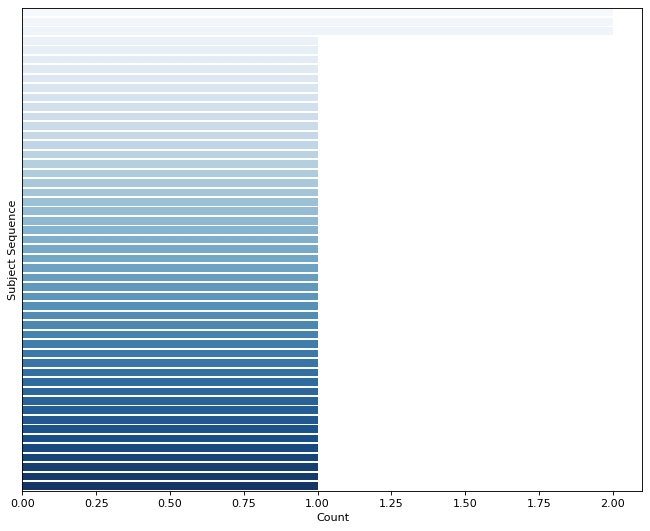

In [187]:
# Create a barplot for the hits for the one selected query sequence

figure(figsize=(10, 8), dpi=80)
ax = sns.barplot(x=counts.values, y=counts.index, palette='Blues'),
ax[0].set_yticks([])
plt.xlabel('Count')
plt.ylabel('Subject Sequence')

In [14]:
# Create a dataframe for working with ID's

merged = pd.merge(df[['query_seq', 'id']], grouped, on='query_seq')
merged = pd.merge(merged, grouped_counts[['query_seq', 'nunique']], on='query_seq')
result = merged.groupby(['id', 'query_seq'])['subject_seq'].nunique().reset_index(name='counts')
result

,id,query_seq,counts
0,sp|Q16620|NTRK2_HUMAN,ARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCSDPSPGIVAFPRL...,1
1,sp|Q16620|NTRK2_HUMAN,FIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSNL...,2
2,sp|Q16620|NTRK2_HUMAN,FIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSNL...,3
3,sp|Q16620|NTRK2_HUMAN,IFIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSN...,1
4,sp|Q16620|NTRK2_HUMAN,IFIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSN...,1
...,...,...,...
2847,tr|Q9X0T1|Q9X0T1_THEMA,VVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIK...,1
2848,tr|Q9X0T1|Q9X0T1_THEMA,VVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIK...,1
2849,tr|Q9X0T1|Q9X0T1_THEMA,VVLAQPKLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVNFQDIK...,1
2850,tr|Q9X0T1|Q9X0T1_THEMA,VVSLVVLAQP-KLTIWCSEKQVDILQKLGEEFKAKYGVEVEVQYVN...,2


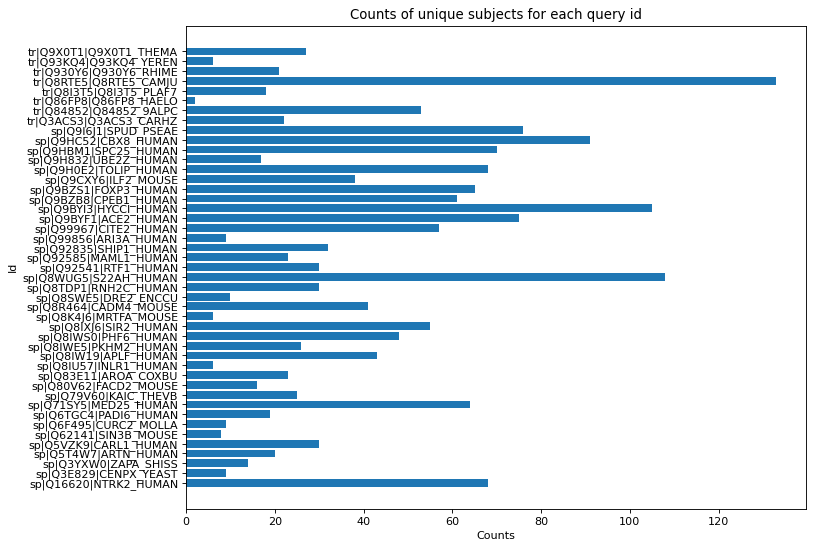

In [15]:
# Create a barplot with the hits for each query ID

figure(figsize=(10, 8), dpi=80)
plt.barh(result['id'], result['counts'])
plt.xlabel('Counts')
plt.ylabel('Id')
plt.title('Counts of unique subjects for each query id')
plt.show()

In [208]:
# Create a hits_matrix 

hits_matrix = df.groupby('query_seq')['subject_seq'].nunique().reset_index()
hits_matrix

,query_seq,subject_seq
0,AAAAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDT...,1
1,AAAAAGGAGGPGSGLAP-LPGLPPSAAAHGAALLSHWDPTLSSDWD...,1
2,AAAAAVAVPLAGGQEGSPGGGRRGSRGTTMVKKRKGRVVIDSDTED...,1
3,AAAAGGAG-GPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDG...,1
4,AAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGE...,1
...,...,...
2847,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2848,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2849,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1
2850,YRNCVYTYRILPNEDDKFTVQASEGVSMRFFTKLDQLIEFYKKENM...,1


In [214]:
# pivot the hits_matrix to create a matrix of counts
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', values='subject_seq', aggfunc='count')
matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
#matrix_of_counts = hits_matrix.pivot_table(index='query_seq', columns='subject_seq', values='count')
matrix_of_counts

KeyError: 'count'

<AxesSubplot:xlabel='query_seq', ylabel='query_seq'>

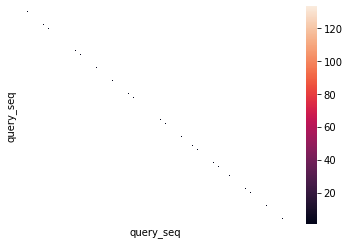

In [206]:
# Plot a heatmap

sns.heatmap(matrix_of_counts, xticklabels=False, yticklabels=False)

In [ ]:
# matrix N query_seq (rows): 2852, M subject_seq (columns): 6855

df['subject_seq'].nunique()

In [ ]:
# Generate the MSA

out_files = ["{}/output.fasta".format(directory)]

for df, out_file in zip(dfs, out_files):
    with open(out_file, "w") as fout:
        for index, row in df.iterrows():
            mapped_seq = ["-"] * max_query_length # Empty list of length = maximum query length
            c = 0
            if row["eval"] < 0.01:
                with open(out_file, "a") as fout: # append the output.fasta
                    for l_q, l_s in zip(row["query_seq"], row["subject_seq"]):
                        if l_q != " " and l_q != "-": # the element in query sequence
                            # avoid 'IndexError: list assignment index out of range'
                            if 1 <= row["query_start"] + c <= max_query_length:
                                mapped_seq[row["query_start"] + c - 1] = l_s if l_s != " " else "-"
                            c += 1
                    fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))